# **Introduction to GNN**

by Ding

This notebook demonstrates node classification by graph neural network (GNN) with a small toy dataset.

Reference: [DGL](https://docs.dgl.ai/en/0.6.x/guide/training-node.html); alternative reference: [UvA](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)

## **1. Graph**

**1.1. View a DGL Dataset**

There are multiple GNN libraries. We use DGL in this notebook for its simplicity.

Note: Install the DGL 0.7.2 version to avoid [a data importation error](https://github.com/dmlc/dgl/issues/3591).


In [ ]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

import numpy as np
import random

import torch

import dgl
import dgl.nn as dglnn
import dgl.data
import torch.nn as nn
import torch.nn.functional as F

Looking in links: https://data.dgl.ai/wheels/repo.html


Download and briefly view a DLG dataset: "CiteseerGraphDataset."

In [ ]:
print("Info:")

dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]

print()
print("Nodes:")
print(graph.ndata)

print()
print("Edges:")
print(graph.edata)

Info:
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.

Nodes:
{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([1, 4, 1,  ..., 5, 3, 3]), 'test_mask': tensor([False, False, False,  ..., False, False, False]), 'train_mask': tensor([False,  True, False,  ..., False, False,  True]), 'val_mask': tensor([False, False, False,  ..., False, False, False])}

Edges:
{}


**1.2. Graph Structure**

Referring to "CiteseerGraphDataset," first of all, generate a small toy dataset.

Create a fully-connnected undirected graph structure with 10 nodes without assgining any value.

In [ ]:
def graph_structure():
  u = []
  v = []
  for i in range(10):
    for j in range(10):
      if j == i:
        pass
      else:
        u.append(i)
        v.append(j)
  return torch.tensor(u), torch.tensor(v)

u, v = graph_structure()

print("Direction (going from the nodes in the first list to the nodes in the second list):")
print(u)
print(v)

graph = dgl.graph((u, v))

print()
print("Graph:")
print(graph)

Direction (going from the nodes in the first list to the nodes in the second list):
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
        7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
        0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8])

Graph:
Graph(num_nodes=10, num_edges=90,
      ndata_schemes={}
      edata_schemes={})


**1.2. Node Feature Tensor**

Randomly generate two types of arrays: $a_1(x)=x$ and $a_2(x)=e^x$, where x is a random number between 0 and 1, with 5 arrays for each type. 

Create binary classes 0 and 1. the $a_1$ array is associated with Class 0, and the $a_2$ array is associated with Class 1.

In [ ]:
def linear(x):
  return x

def exponential(x):
  return np.exp(x)

def node_feature_tensor():
  node_feature = []
  node_class = []
  count = 0
  while count < 10:
    if count < 5:
      node_feature.append(list([linear(i * random.uniform(0, 1)) for i in [1]*10]))
      node_class.append(0)
    else:
      node_feature.append(list([exponential(i * random.uniform(0, 1)) for i in [1]*10]))
      node_class.append(1)
    count += 1
  return torch.tensor(node_feature), torch.tensor(node_class)

node_feature, node_class = node_feature_tensor()

In [ ]:
print("Node features:")
print(node_feature)
print()
print("Node classes:")
print(node_class)

Node features:
tensor([[0.2009, 0.2208, 0.6167, 0.9065, 0.8536, 0.0904, 0.0273, 0.3065, 0.5000,
         0.8761],
        [0.7696, 0.9617, 0.1193, 0.5953, 0.3030, 0.7936, 0.5916, 0.6350, 0.0109,
         0.4817],
        [0.0981, 0.2030, 0.9721, 0.9154, 0.3198, 0.6323, 0.9308, 0.0496, 0.7325,
         0.8514],
        [0.1472, 0.0857, 0.3597, 0.6580, 0.4471, 0.1381, 0.1557, 0.2933, 0.5436,
         0.8067],
        [0.3045, 0.2795, 0.6458, 0.0424, 0.6942, 0.2452, 0.2293, 0.2378, 0.6323,
         0.2729],
        [1.4731, 2.0616, 2.1462, 1.8847, 1.1206, 1.6223, 1.1305, 1.4746, 2.0960,
         1.6367],
        [2.2420, 1.1847, 1.2428, 1.0170, 1.5846, 2.1094, 1.4525, 1.0945, 1.1794,
         1.0150],
        [2.2632, 2.2738, 1.8747, 1.4774, 1.1751, 1.1389, 2.3439, 1.0866, 1.1912,
         2.2994],
        [2.3384, 2.2460, 1.5069, 2.2490, 2.4377, 2.3639, 2.0764, 1.5938, 1.0991,
         1.3506],
        [1.3934, 1.1746, 1.2304, 1.6686, 1.9157, 2.1198, 1.3452, 1.1554, 1.5796,
         2.26

Connect the node features and the node classes with the graph.

In [ ]:
graph.ndata["feat"] = node_feature
graph.ndata["label"] = node_class

**1.3. Training, Validation and Test Nodes**

Use 7 nodes for traning, 1 node for validation and 2 nodes for testing. Create the three corresponding mask tensors.

In [ ]:
def masks():
  train = [True] * 10
  val = [False] * 10
  test = [False] * 10
  val_node, test_node_1, test_node_2 = random.sample(range(0, 10), 3)
  train[val_node], train[test_node_1], train[test_node_2] = False, False, False
  val[val_node] = True
  test[test_node_1], test[test_node_2] = True, True
  return torch.tensor(train), torch.tensor(val), torch.tensor(test)

train_mask, val_mask, test_mask = masks()

print("Training mask:")
print(train_mask)
print()
print("Validation mask:")
print(val_mask)
print()
print("Test mask:")
print(test_mask)

Training mask:
tensor([ True,  True, False, False,  True, False,  True,  True,  True,  True])

Validation mask:
tensor([False, False, False, False, False,  True, False, False, False, False])

Test mask:
tensor([False, False,  True,  True, False, False, False, False, False, False])


Connect the masks with the graph.

In [ ]:
graph.ndata["train_mask"] = train_mask
graph.ndata["val_mask"] = val_mask
graph.ndata["test_mask"] = test_mask

**1.4. Edge Weight Tensor**

Assign weights to the edges. Manually, assign a greater weight 0.8 to the edges between the nodes in the same class, and assign a smaller weight 0.3 otherwise.

In [ ]:
def weights():
  weights = []
  class_0 = [0, 1, 2, 3, 4]
  class_1 = [5, 6, 7, 8, 9]
  for i in range(len(u)):
    if (u[i] in class_0 and v[i] in class_0) or (u[i] in class_1 and v[i] in class_1):
      weights.append(0.8)
    else:
      weights.append(0.3)
  return torch.tensor(weights)

w = weights()

print("Edge weights:")
print(w)

Edge weights:
tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.8000, 0.8000, 0.8000, 0.8000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.8000, 0.8000, 0.8000, 0.8000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.8000, 0.8000, 0.8000, 0.8000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.8000, 0.8000, 0.8000, 0.8000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.8000, 0.8000, 0.8000, 0.8000])


Connect the edge weights with the graph.

In [ ]:
graph.edata['w'] = w 

Look at the graph we generated.

In [ ]:
print(graph)

Graph(num_nodes=10, num_edges=90,
      ndata_schemes={'feat': Scheme(shape=(10,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)})


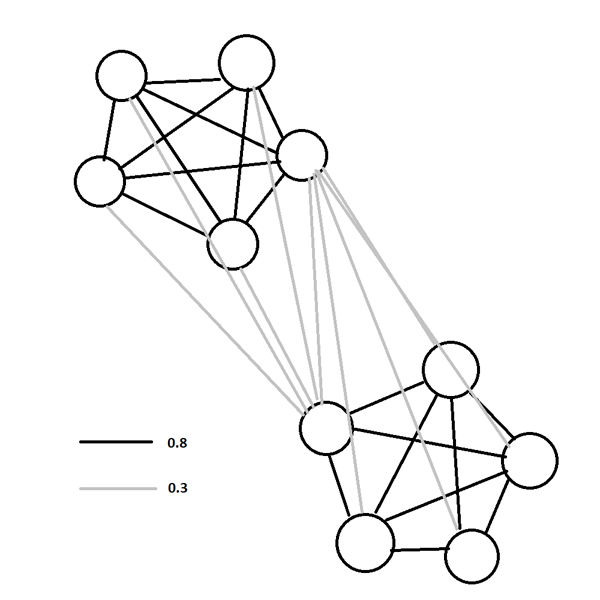

# **2. GNN**

**2.1. Set up a GNN**

Contruct a two-layer GNN model.

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # Inputs are features of nodes.
        h = self.conv1(graph, inputs)
        h = torch.tanh(h)
        h = self.conv2(graph, h)
        return h

Load the variables from the graph.

In [ ]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

**2.2. Node Classification**

Define an evaluation function.

In [ ]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        print("Validation / test observed class:", labels.tolist(), "| predicted class:", indices.tolist())
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Train, validate and test the GNN model for node classification.

Note: Add .float() after node_features to avoid [a runtime error](https://stackoverflow.com/questions/66074684/runtimeerror-expected-scalar-type-double-but-found-float-in-pytorch-cnn-train).

In [ ]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(30):
    print("Epoch:", epoch+1)
    model.train()
    # Forward propagation by using all nodes
    logits = model(graph, node_features.float())
    # Compute loss.
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    # Compute validation accuracy.
    acc = evaluate(model, graph, node_features.float(), node_labels, valid_mask)
    # Backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Training loss: %.4f" % loss.item(), "| validation accuracy:", acc)
    print()

print("--------------------")
test_acc = evaluate(model, graph, node_features.float(), node_labels, test_mask)
print("Test accuracy: ", test_acc)

Epoch: 1
Validation / test observed class: [1] | predicted class: [0]
Training loss: 1.2007 | validation accuracy: 0.0

Epoch: 2
Validation / test observed class: [1] | predicted class: [0]
Training loss: 1.0907 | validation accuracy: 0.0

Epoch: 3
Validation / test observed class: [1] | predicted class: [1]
Training loss: 1.0097 | validation accuracy: 1.0

Epoch: 4
Validation / test observed class: [1] | predicted class: [1]
Training loss: 0.9310 | validation accuracy: 1.0

Epoch: 5
Validation / test observed class: [1] | predicted class: [1]
Training loss: 0.8507 | validation accuracy: 1.0

Epoch: 6
Validation / test observed class: [1] | predicted class: [1]
Training loss: 0.7728 | validation accuracy: 1.0

Epoch: 7
Validation / test observed class: [1] | predicted class: [1]
Training loss: 0.7014 | validation accuracy: 1.0

Epoch: 8
Validation / test observed class: [1] | predicted class: [1]
Training loss: 0.6381 | validation accuracy: 1.0

Epoch: 9
Validation / test observed clas

**2.3. Node Regression**



We need to change the graph. Instead of assigning a class to a node, assign a ground truth number to every node.

Generate some random numbers for the 10 nodes.

In [ ]:
def node_ground_truth_number():
  node_number = []
  count = 0
  while count < 10:
    if count < 5:
      node_number.append(random.uniform(0.1, 0.4))
    else:
      node_number.append(random.uniform(0.6, 0.9))
    count += 1
  return torch.tensor(node_number)

node_number = node_ground_truth_number()

graph.ndata['label'] = node_number

In [ ]:
node_labels = graph.ndata['label']

Slightly modify the code in 2.2 and convert the task into a regression task.

The changed lines are followed by a sharp symbol (#).

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # Inputs are features of nodes.
        h = self.conv1(graph, inputs)
        h = torch.sigmoid(h) #
        h = self.conv2(graph, h)
        return h

In [ ]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        values = model(graph, features) #
        values = torch.squeeze(values[mask]) #
        labels = torch.squeeze(labels[mask]) #
        print("Validation / test observed number:", labels.tolist(), "| predicted number:", values.tolist()) #
        mse = ((values - labels) ** 2).mean() #
        return mse #

In [ ]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=1)
opt = torch.optim.Adam(model.parameters(), lr=0.001) #

for epoch in range(50): #
    print("Epoch:", epoch+1)
    model.train()
    # Forward propagation by using all nodes
    values = model(graph, node_features.float()) #
    # Compute loss.
    loss = ((values[train_mask] - node_labels[train_mask]) ** 2).mean() #
    # Compute validation MSE.
    mse = evaluate(model, graph, node_features.float(), node_labels, valid_mask) #
    mse = mse.tolist() #
    # Backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Training loss: %.4f" % loss.item(), "| validation MSE: %.4f" % mse) #
    print()

print("--------------------")
test_mse = evaluate(model, graph, node_features.float(), node_labels, test_mask) #
test_mse = test_mse.tolist() #
print("Test MSE: %.4f" % test_mse) #

Epoch: 1
Validation / test observed number: 0.6702939867973328 | predicted number: 0.555672287940979
Training loss: 0.0772 | validation MSE: 0.0131

Epoch: 2
Validation / test observed number: 0.6702939867973328 | predicted number: 0.37360233068466187
Training loss: 0.0862 | validation MSE: 0.0880

Epoch: 3
Validation / test observed number: 0.6702939867973328 | predicted number: 0.4537048041820526
Training loss: 0.0721 | validation MSE: 0.0469

Epoch: 4
Validation / test observed number: 0.6702939867973328 | predicted number: 0.5595546960830688
Training loss: 0.0688 | validation MSE: 0.0123

Epoch: 5
Validation / test observed number: 0.6702939867973328 | predicted number: 0.6176486611366272
Training loss: 0.0731 | validation MSE: 0.0028

Epoch: 6
Validation / test observed number: 0.6702939867973328 | predicted number: 0.6119454503059387
Training loss: 0.0697 | validation MSE: 0.0034

Epoch: 7
Validation / test observed number: 0.6702939867973328 | predicted number: 0.571127057075500